In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install BackTranslation
!pip install nlpaug

In [3]:
import pandas as pd
from BackTranslation import BackTranslation
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep

#If you get "AttributeError: 'Translator' object has no attribute 'raise_Exception'", change your IP adress using a VPN.


CSV_Path ="/content/drive/MyDrive/Algoritmos/Datathon/Datos/DataSet (Augmentation.test).csv"
LANG = 'en'
OLANG = 'es'
API = 'google'

def translate(df, LANG, OLANG):
    translations = {}
    trans = BackTranslation()
    
    df_en = df.copy()
    trans.raise_Exception = True

    for element in df_en['Item (Texto)'].unique():
        sleep(1)
        try:
            translations[element] =  trans.translate(element, src=OLANG, tmp = LANG).result_text
        except TypeError:
            translations[element] = element
    df_en.replace(translations, inplace = True)
    
    return df_en

In [4]:
def augmen(df):
    augmentation = {}
    aug = naw.SynonymAug(aug_src='wordnet', lang='spa')
    
    df_a = df.copy()
    df_a = df_a.drop(df_a[(df_a['GravedadMode']=='2')].index)
    df_a = df_a.drop(df_a[(df_a['GravedadMode']=='1')].index)
    df_a = df_a.drop(df_a[(df_a['GravedadMode']=='3')].index)

    for element in df_a['Item (Texto)'].unique():
        augmentation[element] =  aug.augment(element)

    df_a.replace(augmentation, inplace = True)
    
    return df_a

In [5]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [6]:
import nlpaug.augmenter.word as naw

df = pd.read_csv(CSV_Path, header = 0)
df['GravedadMode'] = df['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
df['SesgoMode'] = df['Sesgo'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
df = df[['Item (Texto)', 'GravedadMode', 'SesgoMode']]
    
df2 = pd.concat([df, augmen(df)], ignore_index=True, sort=False)

In [7]:
from sklearn.model_selection import train_test_split

df = df2
x = df['Item (Texto)'].values
y = df['GravedadMode'].values
    
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.25, random_state = 0)
df2 = pd.DataFrame(columns = ['Item (Texto)' , 'GravedadMode'])
df3 = pd.DataFrame(columns = ['Item (Texto)' , 'GravedadMode'])
for i in range(len(X_train)):
  df2.loc[i] = [X_train[i],y_train[i]]
for i in range(len(X_test)):
  df3.loc[i] = [X_test[i],y_test[i]]
df_concat = pd.concat([df2, translate(df2, LANG, OLANG)], ignore_index=True, sort=False)


In [8]:
from tensorflow import keras
%tensorflow_version 2.x

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [10]:
X_train = df_concat['Item (Texto)'].values
y_train = df_concat['GravedadMode'].values

X_test = df3['Item (Texto)'].values
y_test = df3['GravedadMode'].values

In [11]:
t = Tokenizer()
t.fit_on_texts(X_train)
t.fit_on_texts(X_test)

In [12]:
vocab_size = len(t.word_index) + 1
print(vocab_size)

4134


In [13]:
sequences1 = t.texts_to_sequences(X_train)
sequences2 = t.texts_to_sequences(X_test)

In [14]:
import numpy as np

np.shape(sequences1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(276,)

In [15]:
def max_news(seq):
    for i in range(1, len(seq)):
        max_length = len(seq[0])
        if len(seq[i]) > max_length:
            max_length = len(seq[i])
    return max_length

In [16]:
news_num1 = max_news(seq = sequences1)
news_num1

139

In [17]:
news_num2 = max_news(seq = sequences2)
news_num2

75

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_x_train = pad_sequences(sequences1, padding='pre', maxlen=max(news_num1, news_num2))
padded_x_test = pad_sequences(sequences2, padding='pre', maxlen=max(news_num1, news_num2))

In [20]:
import numpy as np

labels_train = to_categorical(np.asarray(y_train))
labels_test = to_categorical(np.asarray(y_test))

In [21]:
X_train, X_test, y_train, y_test = padded_x_train, padded_x_test, labels_train, labels_test

In [22]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (276, 139)
y_train size: (276, 4)
X_test size: (46, 139)
y_test size: (46, 4)


In [23]:
import os

In [24]:
cd /content/drive/MyDrive/Algoritmos/Datathon/Embeddings

/content/drive/MyDrive/Algoritmos/Datathon/Embeddings


In [25]:
ls

checkpoint/  embeddings-l-model.vec  fasttext-sbwc.300k.vec


In [ ]:
# from gensim.models import KeyedVectors
# import logging

# logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

# vectors = KeyedVectors.load_word2vec_format('embeddings-l-model.vec', binary = False)

In [26]:
import numpy as np

embeddings_index = dict()
f = open('embeddings-l-model.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1313424 word vectors.


In [27]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
# Definición del tamaño de la matriz embedding: Número de palabas únicas x dimensión del embedding (100)
embedding_matrix = np.zeros((vocab_size, 300))

# relleno de la matriz
for word, i in t.word_index.items():  # diccionario
    embedding_vector = embeddings_index.get(word) # obtención de los vectores embedded de la palabra en GloVe.
    if embedding_vector is not None:
        # adición en la matriz
        embedding_matrix[i] = embedding_vector # cada fila de la matriz.

In [30]:
keras.backend.clear_session()

# Creación de la capa embedding esando la matriz embedding predefinida.
from tensorflow.keras.layers import Embedding

# la entrada será vocab_size, y la salida 300
# para cargar los pesos de la matriz embedding hacemos trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],
                           input_length = max(news_num1, news_num2), trainable=True)

In [31]:
mod = Sequential()
mod.add(embedding_layer)
mod.add(Flatten())
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dense(4, activation='softmax'))
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, clipnorm = 1, clipvalue = 0.5)
mod.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 139, 300)          1240200   
_________________________________________________________________
flatten (Flatten)            (None, 41700)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2085050   
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [32]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [33]:
keras.backend.clear_session()

In [34]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('./checkpoint',save_best_only=True, monitor='val_acc', mode='max')

### Validation_Split

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 74.8179 - acc: 0.2318 - val_loss: 74.6175 - val_acc: 0.1786
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 2/500
1/1 [==============================] - 0s 48ms/step - loss: 74.6865 - acc: 0.2136 - val_loss: 74.4253 - val_acc: 0.1964
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 3/500
1/1 [==============================] - 0s 47ms/step - loss: 74.4425 - acc: 0.2545 - val_loss: 74.1811 - val_acc: 0.2143
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 4/500
1/1 [==============================] - 0s 46ms/step - loss: 74.2059 - acc: 0.1864 - val_loss: 73.8928 - val_acc: 0.1964
Epoch 5/500
1/1 [==============================] - 0s 47ms/step - loss: 73.9176 - acc: 0.2682 - val_loss: 73.5639 - val_acc: 0.2143
Epoch 6/500
1/1 [==============================] - 0s 47ms/step - loss: 73.5654 - acc: 0.2545 - val_loss: 73.1980 - val_acc: 0.1964
Epoch 7/500
1/1 [============================

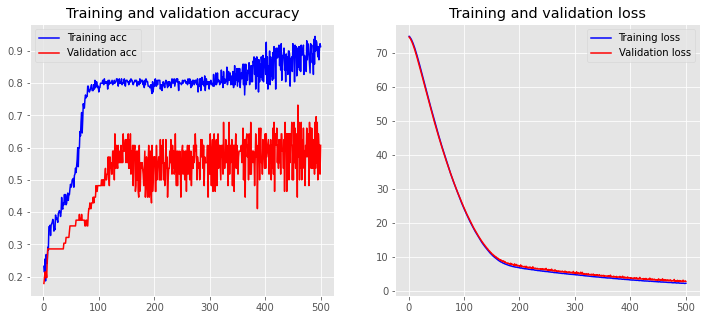

In [35]:
es=EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)

history = mod.fit(X_train, y_train,
                            batch_size=256,
                            epochs=500,
                            validation_split=0.2,
                            callbacks=[es,mcp_save])
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [36]:
mod.load_weights('./checkpoint')


In [37]:
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8478
Testing Accuracy:  0.2609


### Validation_data

Epoch 1/500
2/2 [==============================] - 0s 54ms/step - loss: 1.5458 - acc: 0.8986 - val_loss: 3.2454 - val_acc: 0.3696
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 2/500
2/2 [==============================] - 0s 30ms/step - loss: 1.5878 - acc: 0.8949 - val_loss: 3.2675 - val_acc: 0.3913
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 3/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5147 - acc: 0.9094 - val_loss: 3.4190 - val_acc: 0.4565
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 4/500
2/2 [==============================] - 0s 30ms/step - loss: 1.5396 - acc: 0.8986 - val_loss: 3.4836 - val_acc: 0.3696
Epoch 5/500
2/2 [==============================] - 0s 32ms/step - loss: 1.5680 - acc: 0.8732 - val_loss: 3.1734 - val_acc: 0.3913
Epoch 6/500
2/2 [==============================] - 0s 28ms/step - loss: 1.5714 - acc: 0.8986 - val_loss: 3.4772 - val_acc: 0.4565
Epoch 7/500
2/2 [==============================] - 0s 2

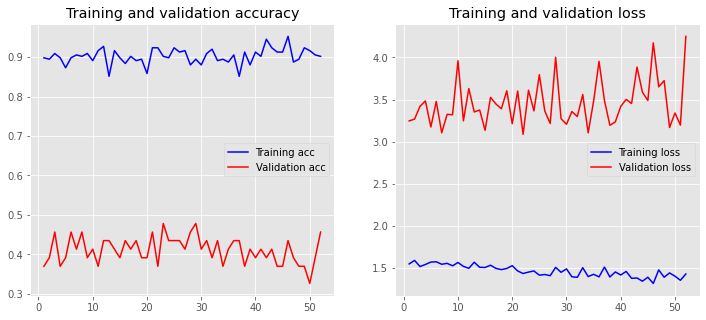

In [40]:
keras.backend.clear_session()
es=EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)
mcp_save = ModelCheckpoint('./checkpoint',save_best_only=True, monitor='val_acc', mode='max')

history = mod.fit(X_train, y_train,
                            batch_size=256,
                            epochs=500,
                            validation_data=(X_test, y_test),
                            callbacks=[es,mcp_save])
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [41]:
mod.load_weights('./checkpoint')


In [42]:
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9891
Testing Accuracy:  0.4783


In [43]:
comentario = ['El presidente en alocución oficial pronunció un discurso de odio y terror para toda la población, incitando al asesinato de todo aquel de la oposición y declarando que la única postura válida en el país era la ultraderecha.']

In [44]:
comentario = t.texts_to_sequences(comentario)


In [45]:
comentario = pad_sequences(comentario, padding = 'pre',maxlen=max(news_num1, news_num2))


In [46]:
np.argmax(mod.predict(comentario), axis=-1)

array([1])